In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transform
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
train_dir = "D:/KMUTT/Year 4th/ENE490 DL/Coding/Dataset/logos3/train"
test_dir = "D:/KMUTT/Year 4th/ENE490 DL/Coding/Dataset/logos3/test"

In [4]:
train_transform = transforms.Compose([
                                   transforms.Resize((300,300)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5]) # [value-mean]/std
                                   ])

In [5]:
# Hyperparameter
#input_size = 1
num_classes = 6
learning_rate = 0.001
batch_size = 128
num_epoch = 5

In [6]:
train_data = torchvision.datasets.ImageFolder(root=train_dir,transform = train_transform)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)



test_data = torchvision.datasets.ImageFolder(root=test_dir,transform = train_transform)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [7]:
train_data

Dataset ImageFolder
    Number of datapoints: 1738
    Root location: D:/KMUTT/Year 4th/ENE490 DL/Coding/Dataset/logos3/train
    StandardTransform
Transform: Compose(
               Resize(size=(300, 300), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [8]:
class CNN(nn.Module):
    def __init__(self,in_channels=3,num_classes=6):
       super(CNN,self).__init__()
       self.conv1  = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=(5,5),stride=(1,1) ,padding='valid')#in: 300*300*3
       self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
       self.conv2  = nn.Conv2d(in_channels=6,out_channels=14,kernel_size=(5,5),stride=(1,1) ,padding='valid')
       self.fc1 = nn.Linear(72*72*14,4096)
       self.fc2 = nn.Linear(4096,1000)
       self.fc3 = nn.Linear(1000,num_classes)

    def forward(self,x):
        x = f.relu(self.conv1(x))
        x = self.pool(x)
        x = f.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0],-1)
        x =f.relu(self.fc1(x))
        x =f.relu(self.fc2(x))
        x =self.fc3(x)
        return x

In [9]:
#Initialize network
model = CNN().to(device)
#loss function network
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

Epoch [1/5], loss:4.831164
Epoch [2/5], loss:1.821114
Epoch [3/5], loss:1.862296
Epoch [4/5], loss:2.471528
Epoch [5/5], loss:2.090580


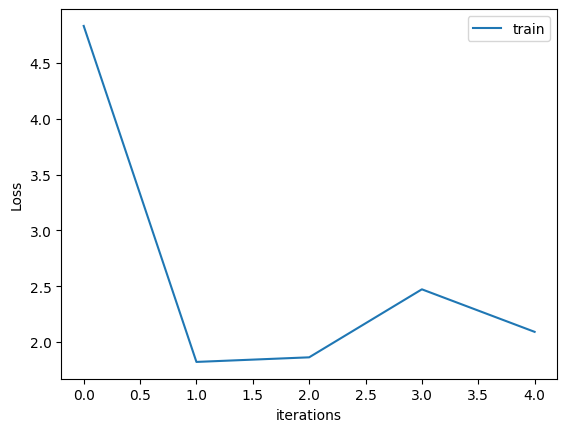

In [10]:
# Train and Network
losses = []
for epoch in range(num_epoch):
    for batch_idx,(data,targets) in enumerate(train_data_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)


        #forward
        score = model(data)
        loss = criterion(score,targets)

        #backward
        optimizer.zero_grad()
        loss.backward()

        #gradient descent or adam step
        optimizer.step()

    losses.append(loss.item())
    #mean_loss = sum(losses) / len(losses)
    #print(f'epoch: {epoch+1}/{num_epoch } loss =  {mean_loss:.5f}')
    print('Epoch [{}/{}], loss:{:4f}'.format(epoch+1,num_epoch,loss.item()))

plt.plot(losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [11]:
def check_accuracy(loader, model):

  num_correct = 0
  num_samples = 0
  model.eval() # -> Evaluate for model


  with torch.no_grad():
    for x, y in loader:
      #when train on GPU
      x=x.type(torch.cuda.FloatTensor)
      y=y.type(torch.cuda.FloatTensor)

      #CPU
      #x = x.to(device=device)
      #y = y.to(device=device)


      scores = model(x) # CNN
      _, predictions = scores.max(1)
      num_correct += (predictions==y).sum()
      num_samples += predictions.size(0)

  print(f'got {num_correct} / {num_samples}   Accuracy {(float(num_correct)/float(num_samples)*100)}')

  model.train()

In [12]:
check_accuracy(train_data_loader, model)
check_accuracy(test_data_loader, model)

got 815 / 1738   Accuracy 46.89298043728424
got 223 / 560   Accuracy 39.82142857142857


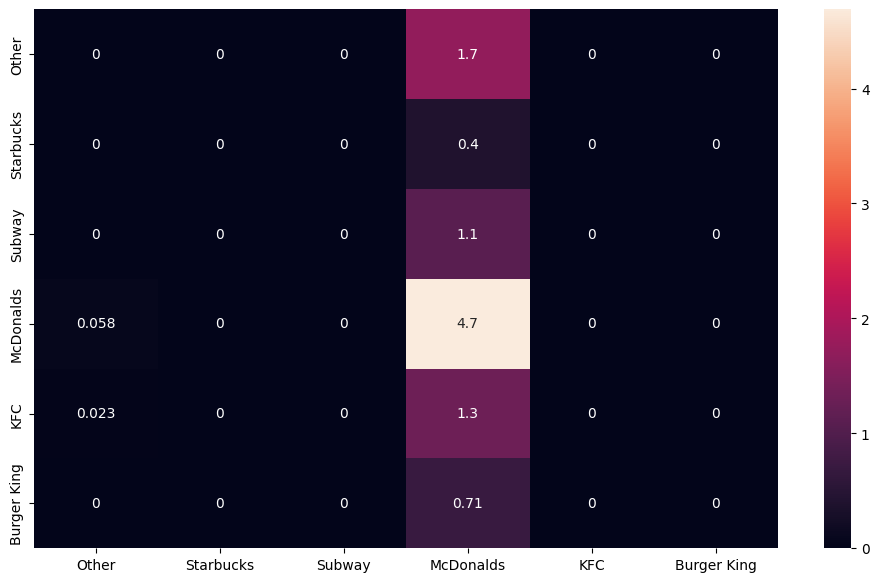

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np


y_pred = []
y_true = []

# iterate over test data
for inputs, labels in train_data_loader:
        #when train on GPU
        inputs=inputs.type(torch.cuda.FloatTensor)
        labels=labels.type(torch.cuda.FloatTensor)


        output = model(inputs) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        #output = output.reshape(output.shape[0], -1)
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Other', 'Starbucks', 'Subway', 'McDonalds', 'KFC', 'Burger King')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('./ConfMatrix/confusion.png')